##1. Download and Import Packages

In [ ]:
!pip install optuna
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.5 MB/s eta 0:00:00


##2. Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read csv
df = pd.read_csv("/content/drive/MyDrive/bt4012/final_dataset.csv")

In [ ]:
df

,AccidentArea,Sex,Age,Fault,FraudFound_P,Deductible,DriverRating,PoliceReportFiled,WitnessPresent,AgentType,...,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability,DaysClaimProcessingDelay,DaysAccidentToClaimDelay,InvalidClaimProcessingDelay,DeductibleVehiclePriceRatio
0,1,1,21.0,0,0,5.707110,1,0,0,0,...,0,1,0,0,0,1,0.000000,0.0,1,0.004000
1,1,0,34.0,0,0,5.993961,4,1,0,0,...,0,1,0,0,1,0,1.791759,0.0,0,0.005333
2,1,0,47.0,0,0,5.993961,3,0,0,0,...,0,1,0,0,1,0,2.564949,0.0,0,0.005333
3,0,0,65.0,1,0,5.993961,2,1,0,0,...,0,1,0,0,0,1,3.135494,0.0,0,0.016327
4,1,1,27.0,1,0,5.993961,1,0,0,0,...,0,1,0,0,1,0,2.484907,0.0,0,0.005333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,1,0,35.0,0,1,5.993961,4,0,0,0,...,1,0,0,0,1,0,1.386294,0.0,0,0.016327
15416,1,0,30.0,0,0,5.993961,3,0,0,0,...,0,1,0,0,0,1,1.945910,0.0,0,0.011594
15417,0,0,24.0,0,1,5.993961,4,0,0,0,...,1,0,0,0,1,0,1.945910,0.0,0,0.016327
15418,1,1,34.0,1,0,5.993961,4,0,0,0,...,1,0,0,1,0,0,2.397895,0.0,0,0.016327


##3. Set random state and create train/validation/test split

In [ ]:
random_state = 42

X = df.drop(columns=["FraudFound_P"])
y = df["FraudFound_P"]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=random_state
)

##4. Hyperparameter Tuning with Optuna for XGBoost Model

In [ ]:
cols_to_standardise = [
    "Age", "Deductible", "DriverRating", "MappedVehiclePrice",
    "MappedDaysPolicyAccident", "MappedDaysPolicyClaim",
    "MappedPastNumberOfClaims", "MappedAgeOfVehicle",
    "MappedNumberOfSuppliments", "MappedAddressChangeClaim",
    "MappedNumberOfCars", "DaysClaimProcessingDelay", "DeductibleVehiclePriceRatio", "DaysAccidentToClaimDelay"
]

scoring = {
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), cols_to_standardise)
    ],
    remainder="passthrough"
)

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 0.2),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "tree_method": "hist",
        "use_label_encoder": False,
        "eval_metric": "auc",
        "n_jobs": -1,
        "random_state": random_state
    }

    # Build pipeline
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("xgb", XGBClassifier(**params))
    ])

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_results = cross_validate(
        pipeline, X_train, y_train,
        cv=cv, scoring=scoring, n_jobs=-1
    )

    # Return mean ROC AUC
    return np.mean(cv_results['test_roc_auc'])

study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=random_state)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best ROC AUC:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-11-10 07:48:51,642] A new study created in memory with name: no-name-1a6cd8bc-2389-46a6-b381-cf9cc7c6e759


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-10 07:49:00,512] Trial 0 finished with value: 0.8091033451045277 and parameters: {'n_estimators': 175, 'max_depth': 8, 'learning_rate': 0.08960785365368121, 'min_child_weight': 3, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.011616722433639893, 'scale_pos_weight': 8.795585311974417, 'reg_alpha': 0.06358358856676251, 'reg_lambda': 0.679657809075816}. Best is trial 0 with value: 0.8091033451045277.
[I 2025-11-10 07:49:05,610] Trial 1 finished with value: 0.8043933591914019 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.12106896936002161, 'min_child_weight': 2, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'gamma': 0.06084844859190755, 'scale_pos_weight': 5.72280788469014, 'reg_alpha': 0.01976218934028007, 'reg_lambda': 0.014618962793704957}. Best is trial 0 with value: 0.8091033451045277.
[I 2025-11-10 07:49:10,199] Trial 2 finished with value: 0.8265253306683327 and parameters: {'n_esti

In [ ]:
best_params = study.best_params
best_params.update(
    {
        "use_label_encoder": False,
        "eval_metric": "logloss",
        "random_state": random_state,
        "tree_method": "hist"
    }
)

best_xgb_pipeline = ImbPipeline([("preprocessor", preprocessor), ("xgb", XGBClassifier(**best_params))])

best_xgb_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:51:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'Deductible',
                                                   'DriverRating',
                                                   'MappedVehiclePrice',
                                                   'MappedDaysPolicyAccident',
                                                   'MappedDaysPolicyClaim',
                                                   'MappedPastNumberOfClaims',
                                                   'MappedAgeOfVehicle',
                                                   'MappedNumberOfSuppliments',
                                                   'MappedAddressChangeClaim',
                                                   'MappedNumberOfCars',
                                                   'DaysCl...
                               gamma=0.1110076468308251, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.03813957344160822, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=159, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
# Get predictions on train and validation sets
y_train_pred = best_xgb_pipeline.predict(X_train)
y_train_proba = best_xgb_pipeline.predict_proba(X_train)[:, 1]

y_val_pred = best_xgb_pipeline.predict(X_val)
y_val_proba = best_xgb_pipeline.predict_proba(X_val)[:, 1]

# Compute metrics
train_roc_auc = roc_auc_score(y_train, y_train_proba)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

val_roc_auc = roc_auc_score(y_val, y_val_proba)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

metrics_df = pd.DataFrame({
    "Metric": ["ROC-AUC", "Precision", "Recall", "F1"],
    "Train (mean)": [train_roc_auc, train_precision, train_recall, train_f1],
    "Validation (mean)": [val_roc_auc, val_precision, val_recall, val_f1]
})

print("Best params:", study.best_params)
print("\nTrain & Validation metrics for best hyperparameters:")
print(metrics_df)

Best params: {'n_estimators': 159, 'max_depth': 3, 'learning_rate': 0.03813957344160822, 'min_child_weight': 1, 'subsample': 0.8423111569751442, 'colsample_bytree': 0.7947627940726579, 'gamma': 0.1110076468308251, 'scale_pos_weight': 4.115642715540866, 'reg_alpha': 0.6257788961212151, 'reg_lambda': 0.07479039904393088}

Train & Validation metrics for best hyperparameters:
      Metric  Train (mean)  Validation (mean)
0    ROC-AUC      0.872513           0.825315
1  Precision      0.467181           0.351351
2     Recall      0.187307           0.141304
3         F1      0.267403           0.201550


In [ ]:
xgboost_val_pred = pd.DataFrame({"y_val_proba": y_val_proba})
xgboost_val_pred.to_csv("/content/drive/MyDrive/bt4012/xgb_val_pred.csv", index=False)

##5. Conduct Business-Optimal Threshold Tuning

In [ ]:
from sklearn.metrics import confusion_matrix
cost_per_false_positive = 1
cost_per_false_negative = 20

best_profit = -float('inf')
best_business_thresh = 0.5

for thresh in thresholds:
    y_pred_class = (y_val_proba > thresh).astype(int)

    # Confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_class).ravel()

    # Calculate profit/loss
    investigation_cost = fp * cost_per_false_positive
    fraud_savings = tp * cost_per_false_negative
    fraud_losses = fn * cost_per_false_negative

    net_benefit = fraud_savings - investigation_cost - fraud_losses

    if net_benefit > best_profit:
        best_profit = net_benefit
        best_business_thresh = thresh

        best_metrics = {
            'Precision': precision_score(y_val, y_pred_class),
            'Recall': recall_score(y_val, y_pred_class),
            'F1': f1_score(y_val, y_pred_class)
        }

print(f"Business-Optimal Threshold: {best_business_thresh:.2f}")
print(f"Net Benefit: {best_profit:,.0f}")
print(f"Metrics: {best_metrics}")

Business-Optimal Threshold: 0.10
Net Benefit: 1,050
Metrics: {'Precision': 0.12850812407680945, 'Recall': 0.9456521739130435, 'F1': 0.22626788036410922}


##6. View Most/Least Influential Features Using SHAP

In [ ]:
import shap
import pandas as pd
import numpy as np

xgb_model = best_xgb_pipeline.named_steps["xgb"]
preprocessor = best_xgb_pipeline.named_steps["preprocessor"]
X_val_transformed = preprocessor.transform(X_val)

if hasattr(X_val_transformed, "toarray"):
    X_val_transformed = X_val_transformed.toarray()

feature_names = preprocessor.get_feature_names_out()

# Use KernelExplainer with model.predict
model_predict = lambda x: xgb_model.predict(x)
explainer = shap.KernelExplainer(model_predict, shap.kmeans(X_val_transformed, 10))

shap_values = explainer.shap_values(X_val_transformed, nsamples=200)

shap_df = pd.DataFrame(shap_values, columns=feature_names)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

importance_df = pd.DataFrame({
    "Feature": mean_abs_shap.index,
    "Mean|SHAP|": mean_abs_shap.values
})

print("\nTop 10 Most Influential Features (XGBoost):")
print(importance_df.head(10))

print("\nBottom 10 Least Influential Features (XGBoost):")
print(importance_df.tail(10))

  0%|          | 0/1542 [00:00<?, ?it/s]


Top 10 Most Influential Features (XGBoost):
                            Feature  Mean|SHAP|
0  remainder__BasePolicy_All Perils    0.013932
1                          num__Age    0.006441
2     num__DaysClaimProcessingDelay    0.006201
3                  remainder__Fault    0.004467
4                   num__Deductible    0.003654
5    num__MappedNumberOfSuppliments    0.002616
6           num__MappedAgeOfVehicle    0.002065
7           num__MappedVehiclePrice    0.002059
8  remainder__VehicleCategory_Sport    0.001882
9     num__MappedAddressChangeClaim    0.001865

Bottom 10 Least Influential Features (XGBoost):
                                 Feature    Mean|SHAP|
88               remainder__Make_Mercury  6.265006e-07
89        remainder__MaritalStatus_Widow  3.911121e-07
90  remainder__DayOfWeekClaimed_Saturday  2.203507e-08
91                remainder__Make_Jaguar  0.000000e+00
92                remainder__Make_Porche  0.000000e+00
93               remainder__Make_Mecedes  0.0000

**After comparison of performance metrics across all models (Logistic Regression, Random Forest, XGBoost and MLP), XGBoost was selected as the best model.**

## 7. Run Final XGBoost Model on Test Set

--- FINAL TEST SET RESULTS (Threshold: 0.1) ---

Test ROC-AUC: 0.8285

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73      2899
           1       0.13      0.97      0.22       185

    accuracy                           0.60      3084
   macro avg       0.56      0.77      0.48      3084
weighted avg       0.94      0.60      0.70      3084


Confusion Matrix Counts:
True Negatives (Correct Non-Fraud): 1665
False Positives (False Alarms): 1234  <-- Costs $1234
False Negatives (Missed Fraud): 6   <-- Costs $120
True Positives (Caught Fraud): 179    <-- Saves $3580

Estimated Net Financial Benefit on Test Set: $2,226


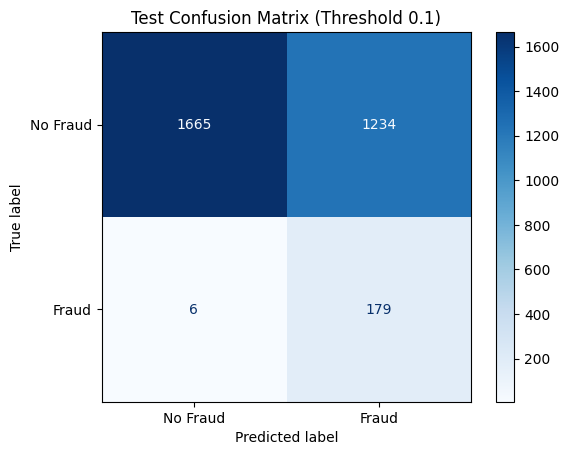

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Get prediction probabilities
y_test_proba = best_xgb_pipeline.predict_proba(X_test)[:, 1]

# Apply optimal threshold
optimal_thresh = best_business_thresh
y_test_pred_opt = (y_test_proba >= optimal_thresh).astype(int)

# Final metrics
print(f"--- FINAL TEST SET RESULTS (Threshold: {optimal_thresh}) ---\n")

# Technical Metrics
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_opt))

# Confusion Matrix (Raw Counts)
cm = confusion_matrix(y_test, y_test_pred_opt)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix Counts:")
print(f"True Negatives (Correct Non-Fraud): {tn}")
print(f"False Positives (False Alarms): {fp}  <-- Costs ${1*fp}")
print(f"False Negatives (Missed Fraud): {fn}   <-- Costs ${20*fn}")
print(f"True Positives (Caught Fraud): {tp}    <-- Saves ${20*tp}")

# Business metrics
cost_per_fp = 1
cost_per_fn = 20
net_benefit = (tp * cost_per_fn) - (fp * cost_per_fp) - (fn * cost_per_fn)

print(f"\nEstimated Net Financial Benefit on Test Set: ${net_benefit:,.0f}")

# Visual Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Fraud", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Test Confusion Matrix (Threshold {optimal_thresh})")
plt.show()